<a href="https://colab.research.google.com/github/ckester23/CS472FinalProject/blob/main/CS472_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("ur mom")
person = "Seth"
print(person+"'s", "mom")

ur mom
Seth's mom


Seth & Maddie's Unholy Contrubution to Society <3

Fuck you Maddie(code section)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 18.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as tk
import numpy as np

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

# Data config
DATA_DIR = './drive/MyDrive/train'
BUFFER = 32  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 20   # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 16  # Offset of slices in the z direction
SHARED_HEIGHT = 4000  # Height to resize all papyrii
NUM_TRAIN_POITNS = 400 # Defines how many points we want to train on
LOAD_MODEL = False
MODEL_FILE = "model.keras"

# Model config
BATCH_SIZE = 32
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

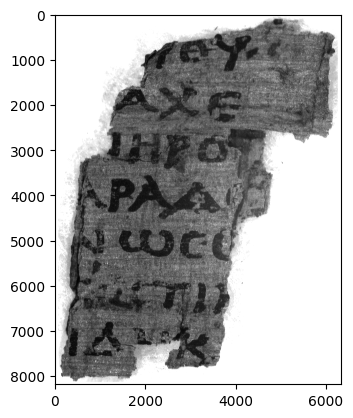

In [ ]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")

In [ ]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        z_slice = np.array(img, dtype="float32")
        z_slices.append(z_slice)
    return tf.stack(z_slices, axis=-1)

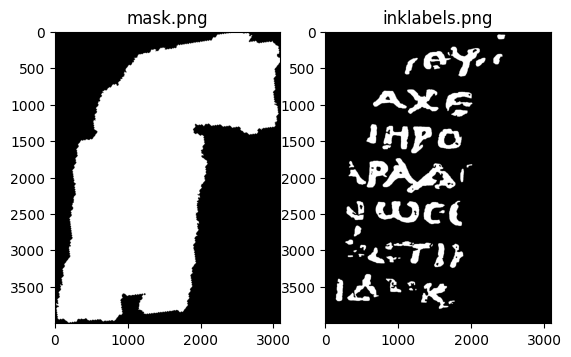

In [ ]:
def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert('1')
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

def load_labels(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

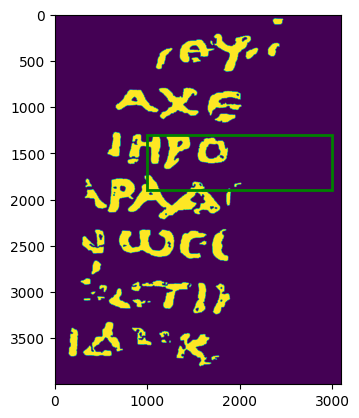

In [ ]:
val_location = (1300, 1000) # Holdout data to validate
val_zone_size = (600, 2000) # Size of that holdout data

fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

In [ ]:
mask_train_1 = load_mask(split="train", index=1)
label_train_1 = load_labels(split="train", index=1)

mask = mask_train_1 # Will add the other two training sets also

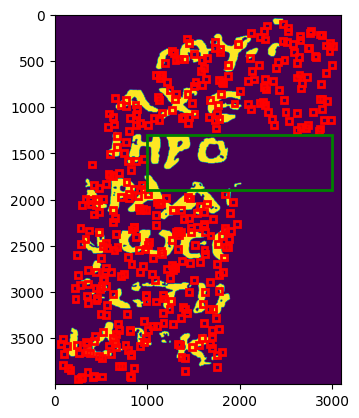

In [ ]:
def sample_random_location(shape): # Get a random point in the data 
    random_train_x = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[0] - BUFFER - 1, dtype="int32")
    random_train_y = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[1] - BUFFER - 1, dtype="int32")
    random_train_location = tf.stack([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask): # checks if a location along with the mask is in said mask
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape) # samples a random location in the data
is_in_mask_train = lambda x: is_in_masked_zone(x, mask) # Checks if the location is within the masked area

def is_in_val_zone(location, val_location, val_zone_size): # checks if location point is in holdout data section
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location): # checks if point is not in holdout and is in training data space
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

#                                                            V This repeat function allows us to gather as main points as we theoretically want
train_locations_ds = tf.data.Dataset.from_tensor_slices([0]).repeat().map(sample_random_location_train, num_parallel_calls=tf.data.AUTOTUNE) # Gathers a bunch of points
train_locations_ds = train_locations_ds.filter(is_proper_train_location) # Checks if they are good points

fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in train_locations_ds.take(NUM_TRAIN_POITNS): # Gather the number of training points
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [ ]:
volume_1 = load_volume(split="train", index=1) # load x-ray volume data
volume = tf.concat([volume_1], axis=1) # combine volumes

del volume_1

def extract_subvolume(location, volume): # Get the volume of sample location
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :] # subvolume shape = (BUFFER*2, BUFFER*2, 20)
    subvolume = tf.cast(subvolume, dtype="float32") / 65535.
    return subvolume

def extract_labels(location, labels): # Get the corresponding training labels
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    label = tf.cast(label, dtype="float32")
    label = tf.expand_dims(label, axis=-1)
    return label

def extract_subvolume_and_label(location): # Get both data and labels
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 4

final_train_ds = train_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
final_train_ds = final_train_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

20it [00:43,  2.17s/it]


In [ ]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

val_locations_ds = tf.data.Dataset.from_tensor_slices(val_locations).filter(is_in_mask_train)
val_ds = val_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

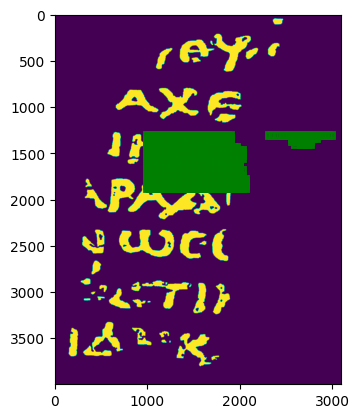

In [ ]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

In [ ]:
augmenter = keras.Sequential([
    layers.RandomContrast(0.2),
])

def augment_train_data(data, label):
    data = augmenter(data)
    return data, label

augmented_train_ds = final_train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


In [ ]:
'''Model from the Kaggle starterkit'''
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    
    x = inputs
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [ ]:
interest_degree = (64*64)//3
def is_interesting(v,l):
    count = 0
    for i in range(BUFFER*2):
        for j in range(BUFFER*2):
            count += l[i][j][-1]
    if count > interest_degree:
        return True
    else:
        return False
sample_ds = val_ds.unbatch().filter(is_interesting).batch(1)

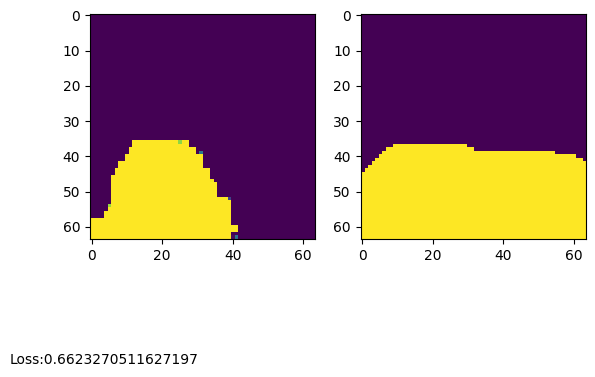


Sample Prediction after epoch 20

200/200 [==============================] - 84s 422ms/step - loss: 0.1131 - accuracy: 0.8725 - binary_io_u_2: 0.8546 - val_loss: 0.2357 - val_accuracy: 0.7512 - val_binary_io_u_2: 0.7324


In [ ]:
from keras.engine.base_layer_utils import training_arg_passed_to_call
'''
 This is where we construct our model paramters and structure
 input shape (BUFFER*2, BUFFER*2, Z_DIM)
'''
from IPython.display import clear_output
do_rate = 0.2
def conv_block(input_tensor, num_filters):

    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    in_prime = layers.Conv2D(num_filters, (1,1), padding='same')(input_tensor)
    x = layers.add([x,in_prime])

    return x

filters = [256, 128, 64]
class IntersectionOverUnionLoss(tf.keras.losses.Loss):

    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
    
        # Convert the y_true and y_pred tensors to binary tensors
        y_true = tf.where(y_true > 0.5, 1.0, 0.0)
        y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    
        # Calculate the intersection over union loss
        loss = 1 - (tf.reduce_sum(y_true * y_pred) + self.smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + self.smooth)
    
        return loss

class TverskyLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=0.5, epsilon=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        y_true_pos = tf.reshape(y_true, [-1])
        y_pred_pos = tf.reshape(y_pred, [-1])
        true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
        false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
        false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
        return 1 - (true_pos + self.epsilon)/(true_pos + self.alpha*false_neg + self.beta*false_pos + self.epsilon)

def step_activation(x): # element wise step fucntion, x_i in [0..1] is now x_i in [0,1]
    x = tf.math.scalar_mul(2.0, x)
    x = tf.math.ceil(x)
    x = tf.math.add(x,-1.0)
    return x

class LogCoshDiceLoss(tf.keras.losses.Loss):
    def __init__(self, epsilon=1e-6):
        super(LogCoshDiceLoss, self).__init__()
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        numerator = 2.0 * tf.reduce_sum(y_true * y_pred, axis=-1)
        denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
        
        dice_score = (numerator + self.epsilon) / (denominator + self.epsilon)
        x = 1 - dice_score
        return tf.math.log((tf.math.exp(x) + tf.math.exp(-x)) / 2.0)

class CombinationLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=0.5, balance=0.5, epsilon=1e-6):
        super(CombinationLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.balance = balance
        self.epsilon = epsilon
    
    def call(self, y_true, y_pred):
        #LogCosh
        numerator = 2.0 * tf.reduce_sum(y_true * y_pred, axis=-1)
        denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
        
        dice_score = (numerator + self.epsilon) / (denominator + self.epsilon)
        x = 1 - dice_score
        logcosh_fin = tf.math.log((tf.math.exp(x) + tf.math.exp(-x)) / 2.0)

        #Tversky
        y_true_pos = tf.reshape(y_true, [-1])
        y_pred_pos = tf.reshape(y_pred, [-1])
        true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
        false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
        false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
        tver_fin = 1 - (true_pos + self.epsilon)/(true_pos + self.alpha*false_neg + self.beta*false_pos + self.epsilon) 
        return ((self.balance*logcosh_fin) + ((1-self.balance)*tver_fin)) / 2.0


def model_builder():
    input_shape = (BUFFER*2, BUFFER*2, Z_DIM) # The 3d volume and the number of color channels(1)
    inputs = layers.Input(input_shape)

    p = inputs 
    skip_connections = []

    # Downsampling
    for f in filters:
        c = conv_block(p, f)
        p = layers.MaxPooling2D(2, strides=(2,2), padding="same")(c)
        skip_connections.append(c)

    # Bottleneck
    bn = conv_block(p, filters[-1])

    skip_connections = list(reversed(skip_connections))

    # Upsampling and establishing the skip connections
    for i, f in enumerate(reversed(filters)):
        bn = keras.layers.UpSampling2D()(bn)
        if i < len(skip_connections):
            bn = layers.concatenate([bn, skip_connections[i]]) # backward residual connection
        bn = conv_block(bn,f)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(bn)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss=CombinationLoss(alpha=0.60, beta=0.40, balance=0.4),
                  optimizer=keras.optimizers.Nadam(weight_decay=0.01),
                  metrics=['accuracy',tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)])
    model.summary()
    return model



if not LOAD_MODEL:
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    IoU = IntersectionOverUnionLoss()
    def show_predictions(dataset=None, num=1):
        if dataset:
            for vol, label in dataset.take(num).as_numpy_iterator():
                  pred_mask = model.predict(vol, batch_size=1)
        else:
            for vol, label in sample_ds.take(num).as_numpy_iterator():
                pred_mask = model.predict(vol)
                samp_loss = IoU.call(label[0], pred_mask[0])
                clear_output(wait=True)
                fig,(ax1,ax2) = plt.subplots(1,2)
                ax1.imshow(pred_mask[0])
                ax2.imshow(label[0])
                plt.figtext(0,0,f"Loss:{samp_loss}")
                plt.show()


    class DisplayCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            show_predictions()
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    model = model_builder()
    model.fit(x=augmented_train_ds,validation_data=val_ds,shuffle=True,epochs=20,steps_per_epoch=200,callbacks=[DisplayCallback()])
    model.save(MODEL_FILE)
else:
    model = keras.models.load_model(MODEL_FILE)
    model.summary()


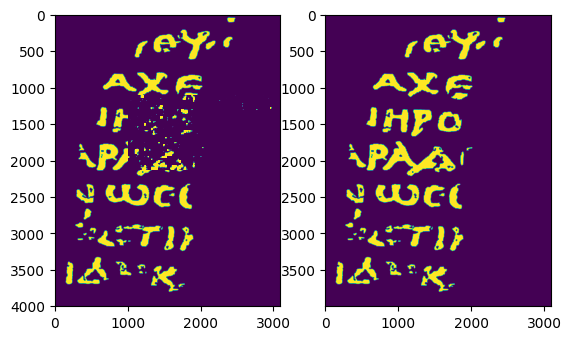

In [ ]:
'''
A visual sanity check on a validation data point
'''
def extract_subv_l_and_loc(location):
    inout = extract_subvolume_and_label(location)
    loc = location
    return inout, loc
test_stride = BUFFER
test_locations = []
for x in range(val_location[0] - BUFFER*6, val_location[0] + val_zone_size[0] + BUFFER*6, val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        test_locations.append((x, y))

test_locations_ds = tf.data.Dataset.from_tensor_slices(test_locations).filter(is_in_mask_train)
test_ds = test_locations_ds.map(extract_subv_l_and_loc, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE).batch(1)

#point = None
#point_label = None
#for v, l in check.as_numpy_iterator():
#    print(np.array(v).shape)
#    print(np.array(l).shape)
#fig, (ax1, ax2) = plt.subplots(1, 2)
#ax1.set_title("prediction")
#ax1.imshow(pred[batch_place])
#ax2.set_title("label")
#ax2.imshow(point_label)
#plt.show()


fig, (ax1,ax2) = plt.subplots(1,2)
img=ax1.imshow(labels)
xmax,ymax=labels.shape
ax2.imshow(labels)
for io, pos in test_ds.as_numpy_iterator(): # calculate predictions and overlay
    v, l = io
    x, y = pos[0]
    pred = model(v)
    extent=(y,y+(2*BUFFER),x+(2*BUFFER),x)
    ax1.imshow(pred[0],extent=extent)
ax1.set(xlim=(0,ymax), ylim=(xmax,0))
plt.show()



In [ ]:
## Free up memory
#del volume
#del mask
#del labels
#del final_train_ds
#del val_ds
#
## Manually trigger garbage collection
keras.backend.clear_session()
import gc
gc.collect()

40